## Optimizing the Continuum Normalization Function
Below, several implementations of the continuum normalization are presented and compared. All versions are adapted to run on several spectra simultaneously.

In [1]:
import numpy as np
from time import time
from astropy.io import fits
import glob
import lmfit
import math
import matplotlib.pyplot as plt

In [2]:
balmer_A = [6564.61, 4862.68, 4341.68, 4102.89, 3971.2, 3890.12, 3835.397]

### Original function

In [3]:
def get_balmer_models(xs, ys):
    res = []
    if len(xs.shape) > 1:
        for i in range(xs.shape[0]):
            res.append(get_balmer_model(xs[i], ys[i]))
    else:
        res.append(get_balmer_model(xs, ys))
    return res

def get_balmer_model(x, y):
    # initialize
    poly_mod = lmfit.models.PolynomialModel(4, prefix='poly_')
    pars = poly_mod.guess(y, x=x)
    
    init_depths = 5 * np.median(poly_mod.eval(pars, x = x))
    vary_center = False
    init_sigma = 5
    
    # H-alpha line
    voigta = lmfit.models.VoigtModel(prefix='va_')
    pars.update(voigta.make_params())
    pars['va_center'].set(value=balmer_A[0], vary = vary_center)
    pars['va_sigma'].set(value=init_sigma, vary = True)
    pars['va_amplitude'].set(value=init_depths, vary = True)
    
    # H-beta line
    voigtb = lmfit.models.VoigtModel(prefix='vb_')
    pars.update(voigtb.make_params())
    pars['vb_center'].set(value=balmer_A[1], vary = vary_center)
    pars['vb_sigma'].set(value=init_sigma, vary = True)
    pars['vb_amplitude'].set(value=init_depths, vary = True)
    
    # H-gamma line
    voigtg = lmfit.models.VoigtModel(prefix='vg_')
    pars.update(voigtg.make_params())
    pars['vg_center'].set(value=balmer_A[2], vary = vary_center)
    pars['vg_sigma'].set(value=init_sigma, vary = True)
    pars['vg_amplitude'].set(value=init_depths, vary = True)
    
    # H-delta line
    voigtd = lmfit.models.VoigtModel(prefix='vd_')
    pars.update(voigtd.make_params())
    pars['vd_center'].set(value=balmer_A[3], vary = vary_center)
    pars['vd_sigma'].set(value=init_sigma, vary = True)
    pars['vd_amplitude'].set(value=init_depths, vary = True)
    
    # H-epsilon line
    voigte = lmfit.models.VoigtModel(prefix='ve_')
    pars.update(voigte.make_params())
    pars['ve_center'].set(value=balmer_A[4], vary = vary_center)
    pars['ve_sigma'].set(value=init_sigma, vary = True)
    pars['ve_amplitude'].set(value=init_depths, vary = True)
    
    # H 8 -> 2
    voigt8 = lmfit.models.VoigtModel(prefix='v8_')
    pars.update(voigt8.make_params())
    pars['v8_center'].set(value=balmer_A[5], vary = vary_center)
    pars['v8_sigma'].set(value=init_sigma, vary = True)
    pars['v8_amplitude'].set(value=init_depths, vary = True)
    
    # H 9 -> 2
    voigt9 = lmfit.models.VoigtModel(prefix='v9_')
    pars.update(voigt9.make_params())
    pars['v9_center'].set(value=balmer_A[6], vary = vary_center)
    pars['v9_sigma'].set(value=10, vary = True)
    pars['v9_amplitude'].set(value=init_depths, vary = True)
    
    # total model
    allvoigts = voigta + voigtb + voigtg + voigtd + voigte + voigt8 + voigt9
    mod = (poly_mod) - (allvoigts)
    
    return poly_mod, mod, pars

def continuum_normalize(xs, ys, make_plot = False):
    # modified for series of xs and ys
    mods_pars = get_balmer_models(xs, ys)
    
    normalized_ys = []
    for i in range(len(mods_pars)):
        poly_mod, mod, pars = mods_pars[i]
        if len(xs[i].shape) > 1:
            x = xs[i]
            y = ys[i]
        else:
            x = xs
            y = ys
        
        out = mod.fit(y, pars, x=x)
        continuum = poly_mod.eval(out.params, x=x)
        normalized_y = y/continuum

        if make_plot:
            init = mod.eval(pars, x=x)

            fig, axes = plt.subplots(1, 2, figsize=(20, 7))
            axes[0].plot(x, y, 'b')
            axes[0].plot(x, init, 'k--', label='initial fit')
            axes[0].plot(x, out.best_fit, 'r-', label='best fit')
            axes[0].legend(loc='best')
            axes[1].plot(x,y)
            axes[1].plot(x, continuum)

            plt.figure()

            plt.plot(x, normalized_y)
        
        normalized_ys.append(y/continuum)

    return normalized_ys


### Minimize explicit loops

In [4]:
def correct_dims(xs, ys):
    if len(xs.shape) <= 1:
        xs = xs.reshape((1, xs.shape[0]))
        ys = ys.reshape((1, ys.shape[0]))
    return xs, ys

def plot_norm(x, y, init, best, cont, norm, figsize=(20,7), save_loc=None, save_fmt='png'):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].plot(x, y, 'b', label='data')
    axes[0].plot(x, init, 'k--', label='initial fit')
    axes[0].plot(x, best, 'r-', label='best fit')
    axes[0].legend(loc='best')
    
    axes[1].plot(x, y)
    axes[1].plot(x, cont)
    
    if save_loc is None:
        plt.show()
    else:
        plt.savefig(save_loc, format=save_fmt)
    
    plt.figure(figsize=figsize)
    plt.plot(x, norm)

In [5]:
def loop_balmer_model(xs, ys, balmer_A=balmer_A):
    polys = []
    models = []
    pars = []
    
    for (x, y) in zip(xs, ys):
        poly = lmfit.models.PolynomialModel(4, prefix='poly_')
        par = poly.guess(y, x=x)
        model = poly
        
        init_sigma = [5] * len(balmer_A)
        init_depth = [5*np.median(poly.eval(par, x=x))] * len(balmer_A)
        init_sigma[len(init_sigma)-1] = 10
        
        for (center, sigma, depth) in zip(balmer_A, init_sigma, init_depth):
            prefix = 'v' + str(center).replace('.', '_') + '_'
            voigt = lmfit.models.VoigtModel(prefix=prefix)
            par.update(voigt.make_params())
            par[prefix + 'center'].set(   value=center, vary=False)
            par[prefix + 'sigma'].set(    value=sigma)
            par[prefix + 'amplitude'].set(value=depth)
            model -= voigt
        
        polys.append(poly)
        models.append(model)
        pars.append(par)
    
    return polys, models, pars

def loop_continuum_normalize(xs, ys, make_plot=False):
    y_norms = []
    
    xs, ys = correct_dims(xs, ys)
    args = loop_balmer_model(xs, ys)
    
    for (poly, model, par, x, y) in zip(*args, xs, ys):
        mfit = model.fit(y, par, x=x)
        y_cont = poly.eval(mfit.params, x=x)
        y_norm = y/y_cont
        y_norms.append(y_norm)
        
        if make_plot:
            plot_norm(x, y, mfit.init_fit, mfit.best_fit, y_cont, y_norm)
    
    return y_norms

## Comparison

In [4]:
def time_func(fn, args=None, kwargs=None):
    start = time()
    
    if args is None and kwargs is None:
        ret = fn()
    elif args is not None and kwargs is None:
        ret = fn(*args)
    elif args is None and kwargs is not None:
        ret = fn(**kwargs)
    else:
        ret = fn(*args, **kwargs)
    
    end = time()
    print('total time:', end-start)
    return ret

In [5]:
files = glob.glob('../data/*.fits')
filename = files[0]
with fits.open(filename) as f:
    y = f[1].data['flux']
    x = 10**f[1].data['loglam']
    v = f[1].data['ivar']

<ipython-input-3-781141d9ef33>:13: RankWarning: Polyfit may be poorly conditioned
  pars = poly_mod.guess(y, x=x)
total time: 3.7729294300079346


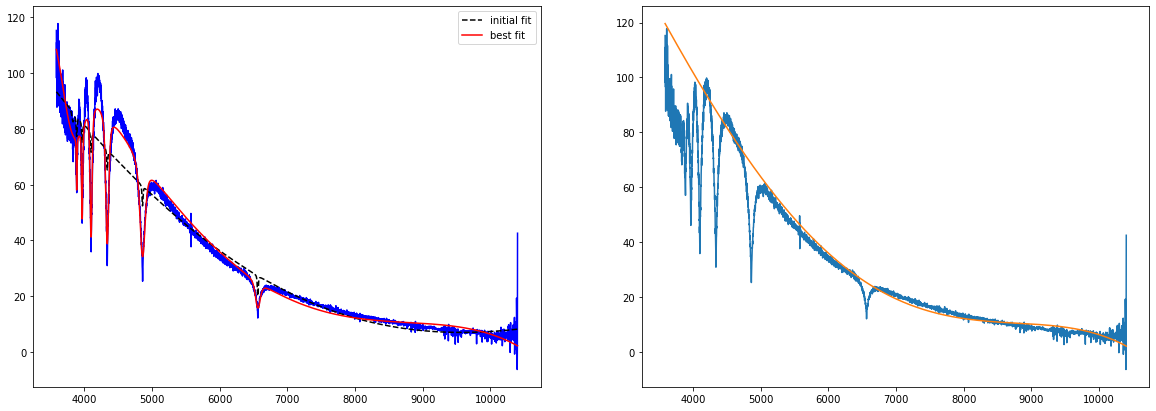

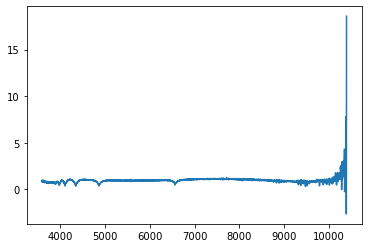

In [6]:
con = time_func(continuum_normalize, (x, y, True))

<ipython-input-5-eb14ad7198d3>:8: RankWarning: Polyfit may be poorly conditioned
  par = poly.guess(y, x=x)


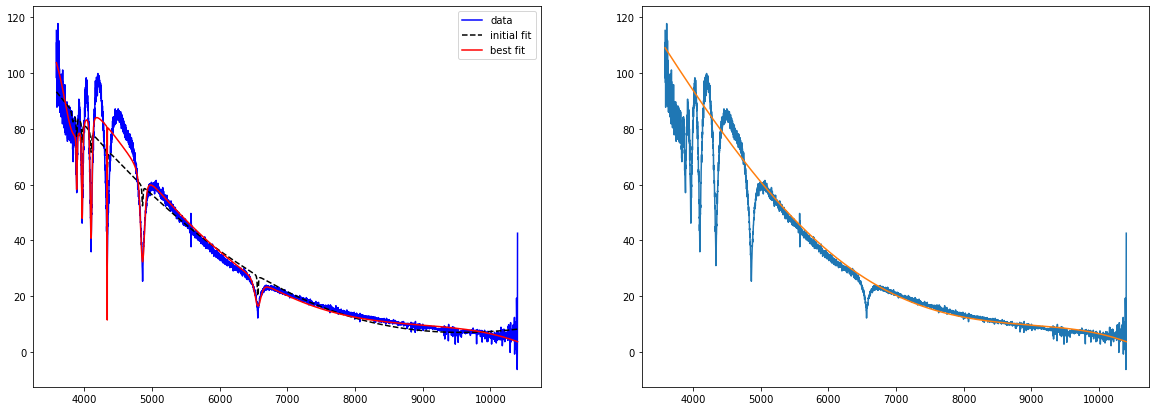

total time: 2.954152822494507


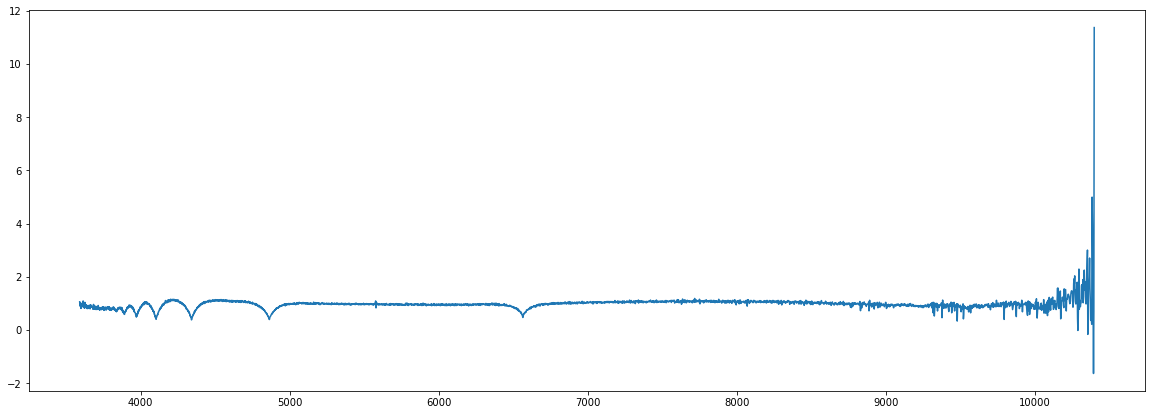

In [9]:
lop = time_func(loop_continuum_normalize, (x, y, True))

### blackbody curve + voigt

In [10]:
def blackbody(x, coeff, temp):
    x_ = x/1e10
    return coeff/(x_**5 * np.expm1(1.4394e-2/x_/temp))

In [11]:
def bb_balmer_model(xs, ys, bb_fn=blackbody, balmer_A=balmer_A):
    bbs = []
    models = []
    pars = []
    
    for (x, y) in zip(xs, ys):
        bb = lmfit.Model(bb_fn)
        par = bb.make_params()
        par['coeff'].set(value=1e-30)
        par['temp'].set(value=1e5, min=1e3, max=1e8)
        model = bb
        
        init_sigma = [6] * len(balmer_A)
        init_depth = [10*np.median(y)] * len(balmer_A)
#         init_sigma[len(init_sigma)-1] = 10
        
        for (center, sigma, depth) in zip(balmer_A, init_sigma, init_depth):
            prefix = 'v' + str(center).replace('.', '_') + '_'
            voigt = lmfit.models.VoigtModel(prefix=prefix)
            par.update(voigt.make_params())
            par[prefix + 'center'].set(   value=center, vary=False)
            par[prefix + 'sigma'].set(    value=sigma)
            par[prefix + 'amplitude'].set(value=depth)
            model -= voigt
        
        bbs.append(bb)
        models.append(model)
        pars.append(par)
    
    return bbs, models, pars

def bb_continuum_normalize(xs, ys, make_plot=False):
    y_norms = []
    
    xs, ys = correct_dims(xs, ys)
    args = bb_balmer_model(xs, ys)
    
    for (bb, model, par, x, y) in zip(*args, xs, ys):
        mfit = model.fit(y, par, x=x)
        y_cont = bb.eval(mfit.params, x=x)
        y_norm = y/y_cont
        y_norms.append(y_norm)
        
        if make_plot:
            plot_norm(x, y, mfit.init_fit, mfit.best_fit, y_cont, y_norm)
    
    return y_norms

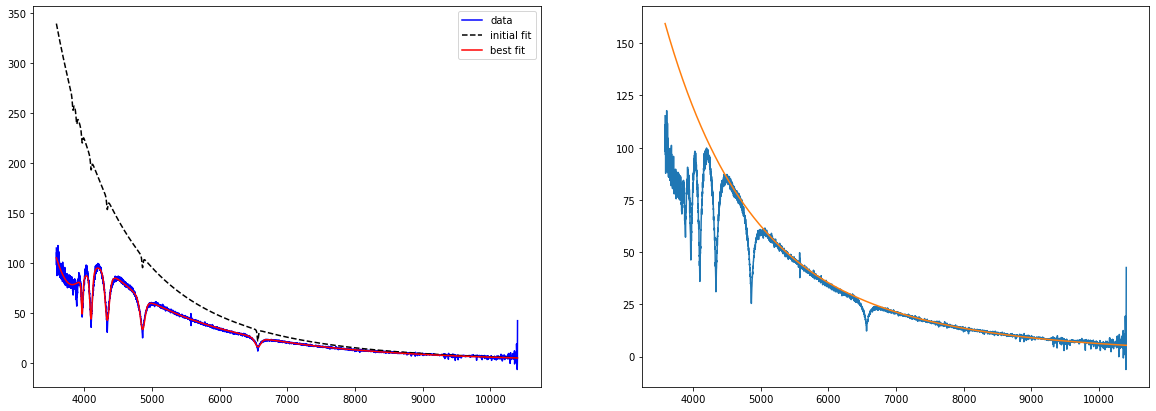

total time: 2.778151512145996


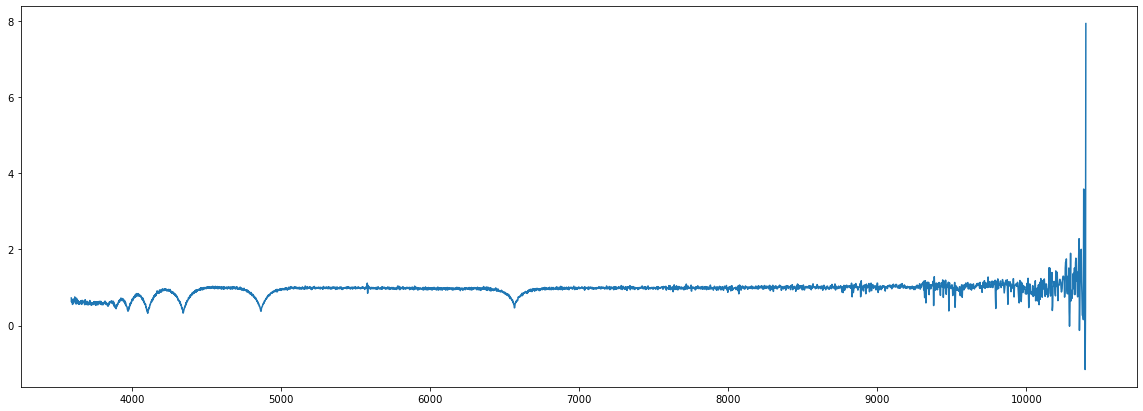

In [12]:
bbc = time_func(bb_continuum_normalize, (x, y, True))

## SE'd ver
- continuum model
  - needs some continuum function
    - initial guess
    - parameter list
- absorption model
  - sum of series of voigts
    - series of centers
    - parameters for each voigt

In [13]:
def absorb_model(x, y, balmer_A=balmer_A):
    sigma = 6
    depth = 10*np.median(y)
    
    model = None
    params = lmfit.Parameters()
    
    for center in balmer_A:
        prefix = 'v' + str(center).replace('.', '_') + '_'
        voigt = lmfit.models.VoigtModel(prefix=prefix)
        params.update(voigt.make_params())
        params[prefix + 'center'].set(   value=center, vary=False)
        params[prefix + 'sigma'].set(    value=sigma)
        params[prefix + 'amplitude'].set(value=depth)
        if model is None:
            model = voigt
        else:
            model += voigt
    
    return model, params

def cont_model(x, y, cont_fn, cont_init):
    model = lmfit.Model(cont_fn)
    params = model.make_params()
    if cont_init is not None:
        for (name, val, var, min, max) in cont_init:
            params[name].set(value=val, vary=var, min=min, max=max)
    
    guess = model.fit(y, params, x=x)
    params = guess.params
    
    return model, params

def balmer_model(x, y, cont_fn, cont_init):
    cnt_model, cnt_params = cont_model(x, y, cont_fn, cont_init)
    abs_model, abs_params = absorb_model(x, y)
    
    model = cnt_model - abs_model
    params = cnt_params + abs_params
    
    return cnt_model, model, params

def cont_norm(x, y, cont_fn, cont_init=None, make_plot=False):
    cnt, mod, prm = balmer_model(x, y, cont_fn, cont_init)
    mfit = mod.fit(y, prm, x=x)
    y_cont = cnt.eval(mfit.params, x=x)
    y_norm = y/y_cont
    
    if make_plot:
        plot_norm(x, y, mfit.init_fit, mfit.best_fit, y_cont, y_norm)
    
    return y_norm, prm

In [14]:
bb_init = [('coeff', 1e-20, True, 1e-40, math.inf), ('temp', 1e5, True, 1e3, 1e8)]

In [15]:
ne = cont_norm(x, y*1e20, blackbody, bb_init, True)

KeyboardInterrupt: 

In [ ]:
print(ne[1])

## Rayleigh-Jeans Curve

In [16]:
def rj_curve(x, A):
    return A/(x/1000)**4

def rj_resid(pars, x, data, ivar):
    expc = rj_curve(x, pars['A'])
    return (data-expc)*np.sqrt(ivar)

rj_par = lmfit.Parameters()
rj_par.add('A', value=1e-3)
fit = lmfit.minimize(rj_resid, rj_par, args=(x, y, v))
fit

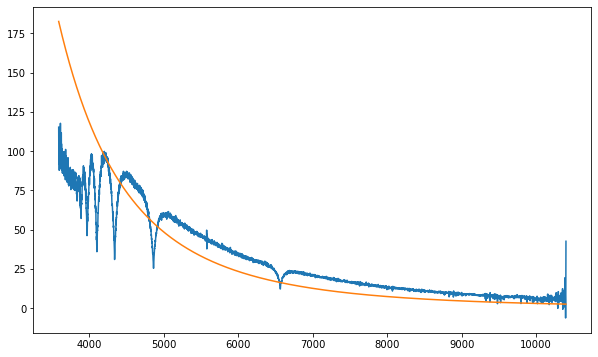

In [17]:
y_rj = rj_curve(x, fit.params['A'])
plt.figure(figsize=(10,6))
plt.plot(x, y)
plt.plot(x, y_rj)